# **Data & AI Engineer – Categorization & Evaluation**

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

### Bring in the given dataset as a Pandas Dataframe

In [2]:
file_path = "/content/Categorized_Transactions_Elle_Jan2025(in).csv"
dataset = pd.read_csv(file_path)


### Data pre-processing

Preprocess the data by filling nulls, identify unique categories, mapping all categories to numerical values, and creating ground truth/predicted labels

In [3]:
# Step 1: Get all distinct categories from both columns (AssignedCategory and Category)
all_categories = pd.concat([dataset['AssignedCategory'], dataset['Category']]).unique()

# Remove 'nan' from the target names list while keeping the NumPy array format
category_names = np.array([category for category in all_categories if category == category])  # filters out NaN


# Step 2: Create a mapping for each category to a unique integer label
category_map = {category: idx for idx, category in enumerate(category_names)}

# Step 3: Replace missing 'Category' values with the value from 'AssignedCategory'
# This assumes that if 'Category' is NaN, AI got it correct, so we use the 'AssignedCategory' value
dataset['Category'] = dataset['Category'].fillna(dataset['AssignedCategory'])

# Step 4: Map both 'AssignedCategory' and 'Category' to numerical labels using the category_map
y_true = dataset['Category'].map(category_map)
y_pred = dataset['AssignedCategory'].map(category_map)

# Step 5: Check for any missing values in y_true or y_pred
print("Missing y_true values (true categories):", y_true.isna().sum())
print("Missing y_pred values (predicted categories):", y_pred.isna().sum())

Missing y_true values (true categories): 0
Missing y_pred values (predicted categories): 0


## ***Task 1***

### **Overall Metrics**

In [4]:
# Step 6: Recalculate Precision, Recall, and F1 Score for the entire dataset

precision = precision_score(y_true, y_pred, average='weighted',zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted',zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted')

# Display the overall scores
print("Overall Precision: ", precision)
print("Overall Recall: ", recall)
print("Overall F1 Score: ", f1)

Overall Precision:  0.8151900758233693
Overall Recall:  0.8170103092783505
Overall F1 Score:  0.7777985260314562


While overall precision and recall are strong (81%), the slightly lower F1 score (78%) reflects inconsistent performance across imbalanced classes. Categories with very few samples underperform or are ignored altogether by the classifier.

### **Classification Report (Per Category Analysis)**

In [5]:
report = classification_report(y_true, y_pred, target_names=category_names, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                                                           precision    recall  f1-score   support

                                 Chair Rental:Hair Chair       0.57      1.00      0.73         8
                                   Chair Rental:Lash Bed       0.86      1.00      0.92         6
                          Computer and Software Expenses       1.00      1.00      1.00         6
                                  Direct Deposit Payable       1.00      1.00      1.00        34
                                    Uncategorized Income       1.00      0.80      0.89        40
                              60400 Bank Service Charges       0.79      1.00      0.88        15
                                   Cash Clearing Account       0.96      1.00      0.98        90
Cost of Goods Sold:Salon Supplies:Supplies and Materials       0.98      1.00      0.99       188
                                         68600 Utilities       0.93      1.00      0.96      

Major classes like “Cost of Goods Sold:Salon Supplies”, “Cash Clearing Account”, and “Utilities” have excellent F1 scores (≥0.95), reflecting high model confidence. In contrast, many low-support categories (e.g., “Gift Expense”, “Charitable Donation”, “Advertising and Promotion”) had an F1 of 0 — likely due to insufficient examples or ambiguous transaction patterns.

### ***Highest and lowest accuracies among all categories***

In [6]:
from sklearn.metrics import confusion_matrix

categories = (category for category in category_names if category == category)

conf_matrix = confusion_matrix(y_true, y_pred)
# Step 2: Calculate accuracy for each category with handling of zero division
category_accuracies = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=1)

# Replace NaN values (where the sum of the row is zero) with 0 accuracy
category_accuracies = np.nan_to_num(category_accuracies, nan=0.0)

# Step 3: Identify categories with the highest and lowest accuracy
max_accuracy_category = category_names[category_accuracies.argmax()]
min_accuracy_category = category_names[category_accuracies.argmin()]

# Print the highest and lowest accuracy categories
print(f"Category with highest accuracy: {max_accuracy_category}")
print(f"Category with lowest accuracy: {min_accuracy_category}")

Category with highest accuracy: Chair Rental:Hair Chair
Category with lowest accuracy: Undeposited Funds


<ipython-input-6-6bf48bf75cb0>:7: RuntimeWarning: invalid value encountered in divide
  category_accuracies = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=1)


### **Confusion Matrix**

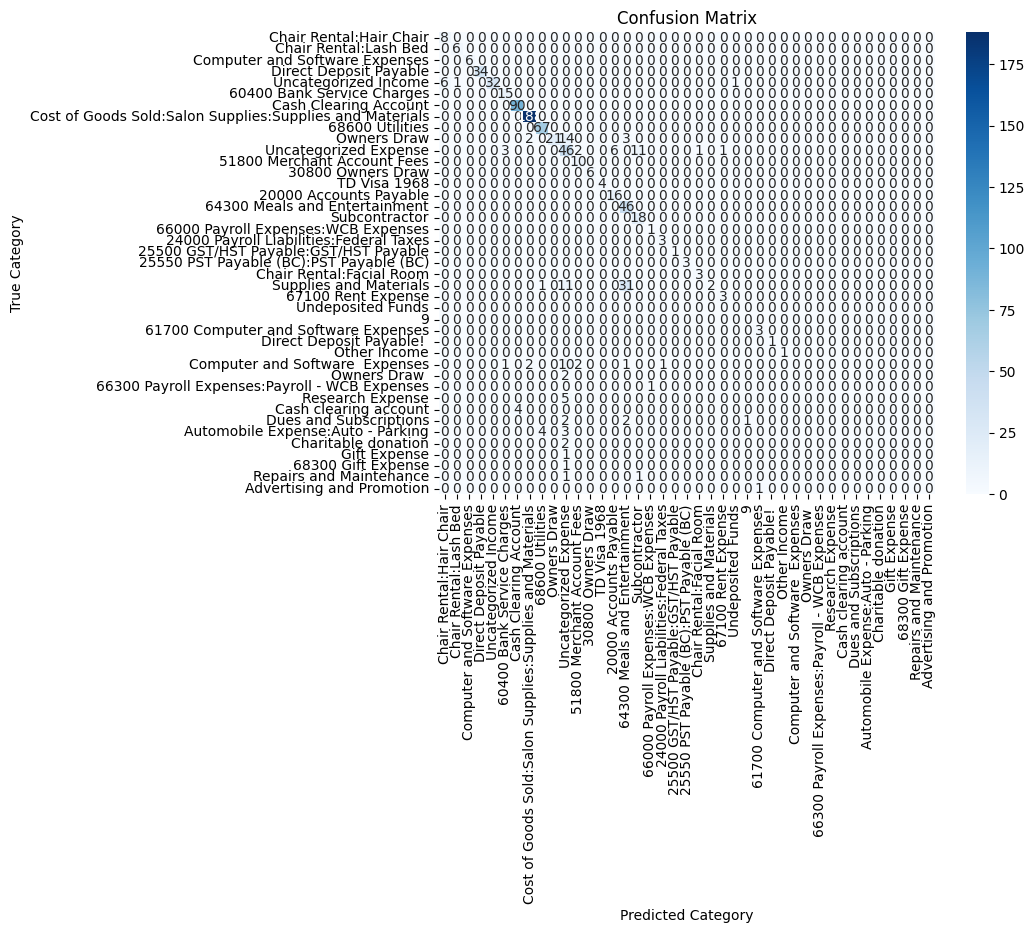

In [24]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.show()


The confusion matrix reveals that a handful of high-volume categories (e.g., "Supplies and Materials", "Cash Clearing Account") dominate prediction space, often overshadowing smaller classes. Misclassifications are clustered in ambiguous transaction types like “Uncategorized Expense” or similar naming variants.

## ***Task 2***

### **Sample of misclassified Data**

In [19]:
# Identify the rows where the AI made a mistake (AssignedCategory != Category)
misclassified_data = dataset[dataset['AssignedCategory'] != dataset['Category']]

# Display a sample of misclassified transactions with AI and human labels
misclassified_data_sample = misclassified_data[['name', 'AssignedCategory', 'Category', 'paymentChannel', 'type']].head()

# Display the sample of misclassified rows
display(misclassified_data_sample)


,name,AssignedCategory,Category,paymentChannel,type
285,SEND E-TFR ***Ygf,Subcontractor,Uncategorized Expense,other,special
286,SEND E-TFR *YBZ AP,Subcontractor,Uncategorized Expense,other,special
300,SEND E-TFR ***hPU,Subcontractor,Uncategorized Expense,other,special
301,SEND E-TFR *BMY AP,Subcontractor,Uncategorized Expense,other,special
302,SEND E-TFR ***H6Y,Subcontractor,Uncategorized Expense,other,special


In [10]:
# Analyze the misclassifications by 'name', 'paymentChannel', and 'type'
misclassified_by_name = misclassified_data['name'].value_counts().head(10)  # Top 10 misclassified names
misclassified_by_payment_channel = misclassified_data['paymentChannel'].value_counts()  # Payment channel analysis
misclassified_by_type = misclassified_data['type'].value_counts()  # Type analysis

# Display the results
print("Top 10 Misclassified Names:\n", misclassified_by_name)
print("\nMisclassified by Payment Channel:\n", misclassified_by_payment_channel)
print("\nMisclassified by Type:\n", misclassified_by_type)


Top 10 Misclassified Names:
 name
CHOICES YALETOWN # 907    28
NANNYSERVICES.CA          10
APPLE.COM/BILL             9
CITY OF VAN PAYBYPHONE     7
TEMU.COM                   6
Netflix                    5
CC.CAREGUIDE.COM           5
SEND E-TFR FEE             5
PHOREST                    4
Phorest Pay-Pho MSP        4
Name: count, dtype: int64

Misclassified by Payment Channel:
 paymentChannel
in store    59
other       43
online      40
Name: count, dtype: int64

Misclassified by Type:
 type
place      90
special    42
digital    10
Name: count, dtype: int64


* Frequent misclassifications stem from vague or generic vendors like CHOICES YALETOWN, APPLE.COM/BILL, and NANNYSERVICES.CA. These repeat offenders likely cause label noise and may benefit from manual review or rule-based overrides.

* Most misclassifications come from place types and in store or other payment channels. This implies the model may be more accurate when clear digital or online metadata is present, and weaker on physical storefronts with ambiguous vendor names.

In [20]:
# Count the number of instances per category in misclassified transactions
misclassified_categories = misclassified_data['AssignedCategory'].value_counts()

# Count the number of instances per category in the entire dataset for comparison
category_counts = dataset['AssignedCategory'].value_counts()

# Combine both counts into a DataFrame for comparison
category_comparison = pd.DataFrame({
    'Total Instances': category_counts,
    'Misclassified Instances': misclassified_categories
}).fillna(0)

# Show categories with the highest number of misclassifications
category_comparison = category_comparison.sort_values(by='Misclassified Instances', ascending=False)

# Display the category comparison
display(category_comparison)`

,Total Instances,Misclassified Instances
AssignedCategory,,
Uncategorized Expense,98,52.0
64300 Meals and Entertainment,83,37.0
Subcontractor,30,12.0
20000 Accounts Payable,22,6.0
Chair Rental:Hair Chair,14,6.0
68600 Utilities,72,5.0
Cash Clearing Account,94,4.0
51800 Merchant Account Fees,14,4.0
Cost of Goods Sold:Salon Supplies:Supplies and Materials,192,4.0


### ***Insights***

* Over 53% of items assigned as “Uncategorized Expense” were misclassified — often transactions like SEND E-TFR, Netflix, Temu, or Apple. These may benefit from custom rules or re-labeling since they tend to be vague, multi-use vendor names.

* Nearly half of the “Meals and Entertainment” entries were misclassified, suggesting ambiguity in dining or lifestyle vendor detection. Adding rules for restaurant chains, delivery platforms, or tagging food-related MCC codes might help.

* The “Subcontractor” class had high misclassification, especially for E-Transfers. The format SEND E-TFR ***[name] is common, and creating a rule or fuzzy match for these could reduce false negatives.

* Some categories (e.g., “Undeposited Funds”, “Research Expense”, “Gift Expense”) had either 0 instances or no correct predictions. These could be deprecated, merged, or re-labeled to reduce fragmentation in the taxonomy.

* Variants like "Owners Draw" vs. "30800 Owners Draw", and "Computer and Software Expenses" vs. "61700..." likely confuse the model. Consolidating such variants can improve model generalization and reduce confusion.

### **Visual Representation of Misclassified Data by Names, pyamentChannel and type**

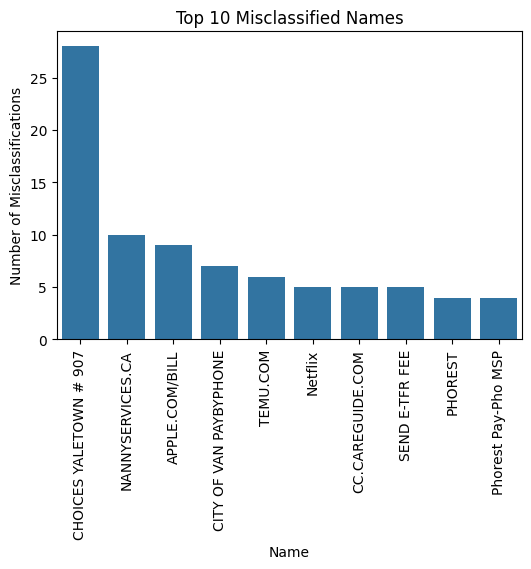

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 10 misclassified names
plt.figure(figsize=(6, 4))
sns.barplot(x=misclassified_by_name.index, y=misclassified_by_name.values)
plt.title("Top 10 Misclassified Names")
plt.xlabel("Name")
plt.ylabel("Number of Misclassifications")
plt.xticks(rotation=90)
plt.show()

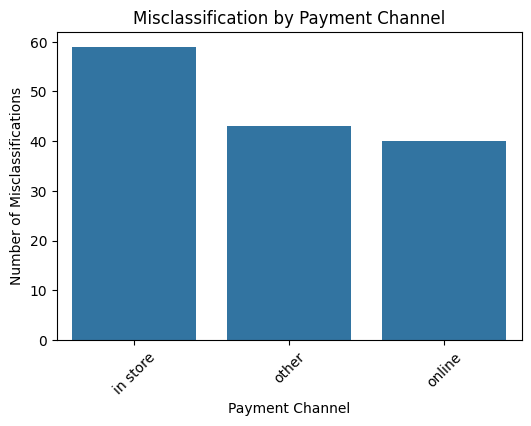

In [22]:
# Plot misclassification by paymentChannel
plt.figure(figsize=(6, 4))
sns.barplot(x=misclassified_by_payment_channel.index, y=misclassified_by_payment_channel.values)
plt.title("Misclassification by Payment Channel")
plt.xlabel("Payment Channel")
plt.ylabel("Number of Misclassifications")
plt.xticks(rotation=45)
plt.show()


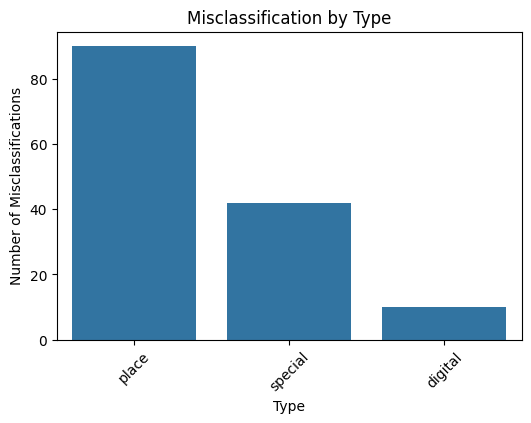

In [23]:
# Plot misclassification by type
plt.figure(figsize=(6, 4))
sns.barplot(x=misclassified_by_type.index, y=misclassified_by_type.values)
plt.title("Misclassification by Type")
plt.xlabel("Type")
plt.ylabel("Number of Misclassifications")
plt.xticks(rotation=45)
plt.show()